In [1]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch
from experiment1_LMD import calc_lmd
from experiment2_TRAN import calc_tran
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
bert_model = "bert-large-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertModel.from_pretrained(bert_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Prompting

In [3]:
def string_to_list(string):
    if string is np.nan:
        return np.nan
    return [float(string_float) for string_float in string[1:-1].split(", ")]

lmd_df = pd.read_csv("data/Experiment1_LMD.csv", index_col=0)[["Compound", "left", "right", "TRAN", "LMD", "bertlarge_nocontext_nospec_lmd", "bertlarge_contextual_lmd"]]
lmd_df["bertlarge_nocontext_nospec_lmd"] = lmd_df["bertlarge_nocontext_nospec_lmd"].apply(string_to_list)
lmd_df["bertlarge_contextual_lmd"] = lmd_df["bertlarge_contextual_lmd"].apply(string_to_list)


lmd_df.Compound = lmd_df.Compound.str.lower()
lmd_df.left = lmd_df.left.str.lower()
lmd_df.right = lmd_df.right.str.lower()

lmd_df

,Compound,left,right,TRAN,LMD,bertlarge_nocontext_nospec_lmd,bertlarge_contextual_lmd
0,aboveground,above,ground,6.200000,4.000000,"[4.048570394515991, 4.107796549797058, 4.20810...","[3.6792556941509247, 3.73639315366745, 3.79268..."
1,airbase,air,base,4.266667,5.866667,"[4.399784505367279, 4.3299901485443115, 4.5135...","[4.297492504119873, 4.437695145606995, 4.66440..."
2,airborne,air,borne,3.857143,3.133333,"[4.62177962064743, 4.605102986097336, 4.559808...","[4.514695107936859, 4.467453062534332, 4.42710..."
3,aircraft,air,craft,4.533333,4.266667,"[4.7790127992630005, 4.752368330955505, 4.7162...","[4.814960062503815, 4.7888994216918945, 4.7258..."
4,airfield,air,field,4.333333,5.714286,"[5.089927613735199, 4.884729087352753, 4.82987...","[4.85325887799263, 4.707901030778885, 4.750182..."
...,...,...,...,...,...,...,...
624,wordplay,word,play,4.928571,3.533333,"[4.117237031459808, 4.207392036914825, 4.26516...","[3.88944610953331, 4.004501104354858, 4.015568..."
625,worldwide,world,wide,4.928571,3.066667,"[4.393830597400665, 4.522831737995148, 4.55298...","[4.272705018520355, 4.3840087950229645, 4.5233..."
626,wristwatch,wrist,watch,6.266667,6.333333,"[4.0012142062187195, 4.10249799489975, 4.20967...","[3.7298889458179474, 3.804171085357666, 3.7654..."
627,yardstick,yards,tick,5.866667,5.333333,"[2.8420887887477875, 3.054892122745514, 3.3275...","[2.6944847404956818, 2.8910107910633087, 3.120..."


In [4]:
def nocontext_vector(
    w,
    tokenizer,
    model,
    subword_pooling="mean",
    special_tokens="nospec",
):

    # Tokenize sentence
    inputs = tokenizer(w, return_tensors="pt")

    if special_tokens == "nospec":
        word_indices = [1+3, -1]

    elif special_tokens == "all":
        word_indices = [0, None]

    elif special_tokens == "withcls":
        word_indices = [0, -1]

    else:
        raise NotImplementedError(
            f"Special tokens {special_tokens} is not implemented."
        )

    # Forward
    outputs = model(**inputs, output_hidden_states=True)

    # Get hidden vectors of the (sub-) words, also skip first hidden. This
    # layer is the output of the embedding layer
    hidden_vectors = [
        layer[:, word_indices[0] : word_indices[-1], :]
        for layer in outputs.hidden_states[1:]
    ]

    # Combine vectors of subwords that belong to the same word
    if subword_pooling == "mean":
        pooled_vectors = []
        for layer in hidden_vectors:
            pooled_vectors.append(torch.mean(layer, 1))

    else:
        raise NotImplementedError(
            f"Subword_pooling {subword_pooling} is not implemented."
        )

    # Return tensor with all hidden vectors for word w
#     words_to_vectors[w] = (
#         torch.stack(pooled_vectors).detach().numpy()
#     )  # TODO: Check if we can do this

    return torch.stack(pooled_vectors).detach().numpy()

def lmd_templated(row,tokenizer,model):
    
    left = row["left"]
    right = row["right"]
    compound = row["Compound"]
    
    
    # Get templated embeddings for each word
    template = "This is a {}"
    
    compound_emb = nocontext_vector(template.replace("{}", compound),tokenizer,model)
    left_emb = nocontext_vector(template.replace("{}", left),tokenizer,model)
    right_emb = nocontext_vector(template.replace("{}", right),tokenizer,model)
    
    # Calculate lmd value for all layers
#     print(compound_emb.shape)
    
    lmds = []
    for layer_i in range(compound_emb.shape[0]):
        lmd_layer = calc_lmd(compound_emb[layer_i], left_emb[layer_i], right_emb[layer_i])
        lmds.append(lmd_layer)
#     print(lmds)
    
    # Return lmd values
    return lmds
    
lmd_df["bertlarge_templeted_nospec_lmd"] = lmd_df.apply(lmd_templated, tokenizer=tokenizer,model=model, axis=1)

In [5]:
lmd_df.dropna(inplace=True)
lmd_df

,Compound,left,right,TRAN,LMD,bertlarge_nocontext_nospec_lmd,bertlarge_contextual_lmd,bertlarge_templeted_nospec_lmd
0,aboveground,above,ground,6.200000,4.000000,"[4.048570394515991, 4.107796549797058, 4.20810...","[3.6792556941509247, 3.73639315366745, 3.79268...","[3.923899084329605, 3.8398946821689606, 3.7369..."
1,airbase,air,base,4.266667,5.866667,"[4.399784505367279, 4.3299901485443115, 4.5135...","[4.297492504119873, 4.437695145606995, 4.66440...","[4.269980192184448, 4.124686121940613, 4.38070..."
2,airborne,air,borne,3.857143,3.133333,"[4.62177962064743, 4.605102986097336, 4.559808...","[4.514695107936859, 4.467453062534332, 4.42710...","[4.583238065242767, 4.487582147121429, 4.53844..."
3,aircraft,air,craft,4.533333,4.266667,"[4.7790127992630005, 4.752368330955505, 4.7162...","[4.814960062503815, 4.7888994216918945, 4.7258...","[4.741661846637726, 4.702582061290741, 4.70962..."
4,airfield,air,field,4.333333,5.714286,"[5.089927613735199, 4.884729087352753, 4.82987...","[4.85325887799263, 4.707901030778885, 4.750182...","[4.928683489561081, 4.659882187843323, 4.54436..."
...,...,...,...,...,...,...,...,...
624,wordplay,word,play,4.928571,3.533333,"[4.117237031459808, 4.207392036914825, 4.26516...","[3.88944610953331, 4.004501104354858, 4.015568...","[4.074739515781403, 4.172292649745941, 4.19348..."
625,worldwide,world,wide,4.928571,3.066667,"[4.393830597400665, 4.522831737995148, 4.55298...","[4.272705018520355, 4.3840087950229645, 4.5233...","[4.394036531448364, 4.387239217758179, 4.49858..."
626,wristwatch,wrist,watch,6.266667,6.333333,"[4.0012142062187195, 4.10249799489975, 4.20967...","[3.7298889458179474, 3.804171085357666, 3.7654...","[3.8025876879692078, 3.905794322490692, 3.9671..."
627,yardstick,yards,tick,5.866667,5.333333,"[2.8420887887477875, 3.054892122745514, 3.3275...","[2.6944847404956818, 2.8910107910633087, 3.120...","[2.824791669845581, 2.992755174636841, 3.22575..."


0.4906268779106033


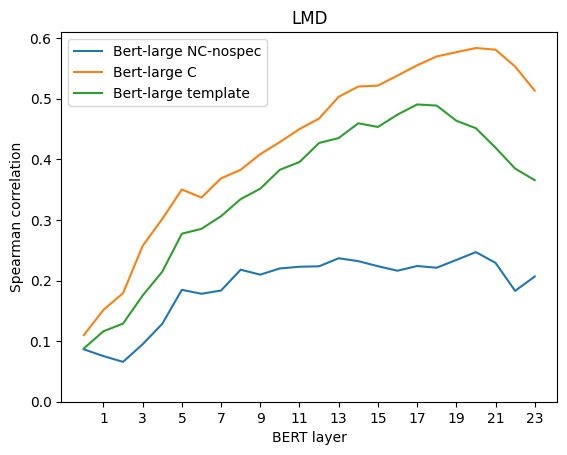

In [7]:
def calc_correlation(real_values, pred_values):
    return spearmanr(pred_values, real_values, axis=0, nan_policy="omit").correlation

def calc_correlation_layers(real_values, layers_values):
    
    # Calculate correlation over layers
    cors = []
    for layer_i in range(layers_values[0].shape[0]):
        layer_i_lmds = [row[layer_i] if row is not np.nan else np.nan for row in layers_values ]
        cor = spearmanr(layer_i_lmds, real_values, axis=0, nan_policy="omit")
        cors.append(cor.correlation)
        
    return cors

def make_plot(df, col_nocont, col_cont, col_temp):
    
    real_lmds = df["LMD"]
    
    nocont = np.stack(df[col_nocont].to_numpy(), axis=0)
    cors_nocont = calc_correlation_layers(real_lmds, nocont)
    
    cont = np.stack(df[col_cont].to_numpy(), axis=0)
    cors_cont = calc_correlation_layers(real_lmds, cont)
    
    temp = np.stack(df[col_temp].to_numpy(), axis=0)
    cors_temp = calc_correlation_layers(real_lmds, temp)
    
    plt.plot(cors_nocont, label="Bert-large NC-nospec")
    plt.plot(cors_cont, label="Bert-large C")
    plt.plot(cors_temp, label="Bert-large template")
    
    print(max(cors_temp))
    
    plt.ylim(0, 0.61)
    plt.xticks(range(1,25,2))
    plt.title("LMD")
    plt.ylabel("Spearman correlation")
    plt.xlabel("BERT layer")
    plt.legend()
#     plt.savefig("plots/LMD_templated.pdf")
    plt.show()
    return 

make_plot(lmd_df, 
          "bertlarge_nocontext_nospec_lmd",
          "bertlarge_contextual_lmd",
          "bertlarge_templeted_nospec_lmd")


# ST

In [8]:
st_df = pd.read_csv("data/Experiment2_TRAN.csv", index_col=0)[["Compound", 
                                                               "left", 
                                                               "right", 
                                                               "TRAN", 
                                                               "LMD", 
                                                               "bertlarge_nocontext_nospec_w=0.5_tran", 
                                                               "bertlarge_contextual_w=0.5_tran"]]
st_df["bertlarge_nocontext_nospec_w=0.5_tran"] = st_df["bertlarge_nocontext_nospec_w=0.5_tran"].apply(string_to_list)
st_df["bertlarge_contextual_w=0.5_tran"] = st_df["bertlarge_contextual_w=0.5_tran"].apply(string_to_list)


st_df.Compound = st_df.Compound.str.lower()
st_df.left = st_df.left.str.lower()
st_df.right = st_df.right.str.lower()

st_df

,Compound,left,right,TRAN,LMD,bertlarge_nocontext_nospec_w=0.5_tran,bertlarge_contextual_w=0.5_tran
0,aboveground,above,ground,6.200000,4.000000,"[4.5776047706604, 4.961236119270325, 5.2530964...","[4.324436694383621, 4.429683983325958, 4.67893..."
1,airbase,air,base,4.266667,5.866667,"[4.722633063793182, 4.847526907920837, 4.81026...","[4.529324293136597, 4.6832462549209595, 4.7129..."
2,airborne,air,borne,3.857143,3.133333,"[3.3438231348991394, 3.86527219414711, 4.26660...","[2.6585548520088196, 2.8587663769721985, 3.022..."
3,aircraft,air,craft,4.533333,4.266667,"[4.170333504676819, 4.887836933135986, 5.08974...","[3.320133686065674, 3.617996037006378, 3.80496..."
4,airfield,air,field,4.333333,5.714286,"[3.613758862018585, 4.286803424358368, 4.64998...","[2.8631000220775604, 3.1926905810832977, 3.520..."
...,...,...,...,...,...,...,...
624,wordplay,word,play,4.928571,3.533333,"[4.808881461620331, 4.931939423084259, 5.05333...","[4.487877279520035, 4.586516499519348, 4.58543..."
625,worldwide,world,wide,4.928571,3.066667,"[3.948649823665619, 4.418403685092926, 4.82602...","[3.1534515619277954, 3.358159989118576, 3.7253..."
626,wristwatch,wrist,watch,6.266667,6.333333,"[4.956519186496735, 5.053432762622833, 5.15155...","[4.758591026067734, 4.856467962265015, 4.87016..."
627,yardstick,yards,tick,5.866667,5.333333,"[4.03953817486763, 4.3798903822898865, 4.73004...","[3.7155435979366302, 3.880307048559189, 4.1094..."


In [9]:
def st_templated(row,tokenizer,model):
    
    left = row["left"]
    right = row["right"]
    compound = row["Compound"]
    
    
    # Get templated embeddings for each word
    template = "This is a {}"
    
    compound_emb = nocontext_vector(template.replace("{}", compound),tokenizer,model)
    left_emb = nocontext_vector(template.replace("{}", left),tokenizer,model)
    right_emb = nocontext_vector(template.replace("{}", right),tokenizer,model)
    
    # Calculate lmd value for all layers
#     print(compound_emb.shape)
    
    sts = []
    for layer_i in range(compound_emb.shape[0]):
        st_layer = calc_tran(compound_emb[layer_i], left_emb[layer_i], right_emb[layer_i], w=.5)
        sts.append(st_layer)
#     print(lmds)
    
    # Return lmd values
    return sts
    
st_df["bertlarge_templeted_nospec_tran"] = st_df.apply(st_templated, tokenizer=tokenizer,model=model, axis=1)

In [10]:
st_df.dropna(inplace=True)
st_df

,Compound,left,right,TRAN,LMD,bertlarge_nocontext_nospec_w=0.5_tran,bertlarge_contextual_w=0.5_tran,bertlarge_templeted_nospec_tran
0,aboveground,above,ground,6.200000,4.000000,"[4.5776047706604, 4.961236119270325, 5.2530964...","[4.324436694383621, 4.429683983325958, 4.67893...","[4.574711292982101, 4.687782496213913, 4.85188..."
1,airbase,air,base,4.266667,5.866667,"[4.722633063793182, 4.847526907920837, 4.81026...","[4.529324293136597, 4.6832462549209595, 4.7129...","[4.729023694992065, 4.800855755805969, 4.66398..."
2,airborne,air,borne,3.857143,3.133333,"[3.3438231348991394, 3.86527219414711, 4.26660...","[2.6585548520088196, 2.8587663769721985, 3.022...","[3.1065688729286194, 3.4260417819023132, 3.561..."
3,aircraft,air,craft,4.533333,4.266667,"[4.170333504676819, 4.887836933135986, 5.08974...","[3.320133686065674, 3.617996037006378, 3.80496...","[3.990198314189911, 4.333427727222443, 4.39641..."
4,airfield,air,field,4.333333,5.714286,"[3.613758862018585, 4.286803424358368, 4.64998...","[2.8631000220775604, 3.1926905810832977, 3.520...","[3.528978615999222, 3.876567244529724, 4.08585..."
...,...,...,...,...,...,...,...,...
624,wordplay,word,play,4.928571,3.533333,"[4.808881461620331, 4.931939423084259, 5.05333...","[4.487877279520035, 4.586516499519348, 4.58543...","[4.703759968280792, 4.7887051701545715, 4.8437..."
625,worldwide,world,wide,4.928571,3.066667,"[3.948649823665619, 4.418403685092926, 4.82602...","[3.1534515619277954, 3.358159989118576, 3.7253...","[3.7791569232940674, 3.9268511533737183, 4.205..."
626,wristwatch,wrist,watch,6.266667,6.333333,"[4.956519186496735, 5.053432762622833, 5.15155...","[4.758591026067734, 4.856467962265015, 4.87016...","[4.869002640247345, 4.983144581317902, 4.99028..."
627,yardstick,yards,tick,5.866667,5.333333,"[4.03953817486763, 4.3798903822898865, 4.73004...","[3.7155435979366302, 3.880307048559189, 4.1094...","[3.8656885623931885, 4.14216673374176, 4.40154..."


0.3078375470739243


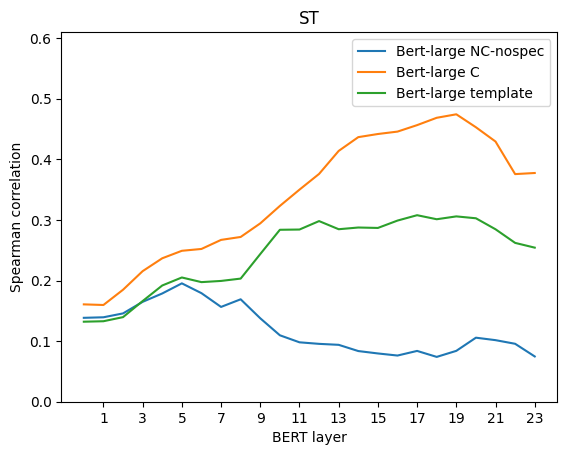

In [12]:
def calc_correlation(real_values, pred_values):
    return spearmanr(pred_values, real_values, axis=0, nan_policy="omit").correlation

def calc_correlation_layers(real_values, layers_values):
    
    # Calculate correlation over layers
    cors = []
    for layer_i in range(layers_values[0].shape[0]):
        layer_i_lmds = [row[layer_i] if row is not np.nan else np.nan for row in layers_values ]
        cor = spearmanr(layer_i_lmds, real_values, axis=0, nan_policy="omit")
        cors.append(cor.correlation)
        
    return cors

def make_plot(df, col_nocont, col_cont, col_temp):
    
    real_sts = df["TRAN"]
    
    nocont = np.stack(df[col_nocont].to_numpy(), axis=0)
    cors_nocont = calc_correlation_layers(real_sts, nocont)
    
    cont = np.stack(df[col_cont].to_numpy(), axis=0)
    cors_cont = calc_correlation_layers(real_sts, cont)
    
    temp = np.stack(df[col_temp].to_numpy(), axis=0)
    cors_temp = calc_correlation_layers(real_sts, temp)
    
    plt.plot(cors_nocont, label="Bert-large NC-nospec")
    plt.plot(cors_cont, label="Bert-large C")
    plt.plot(cors_temp, label="Bert-large template")
    
    print(max(cors_temp))
    
    plt.ylim(0, 0.61)
    plt.xticks(range(1,25,2))
    plt.title("ST")
    plt.ylabel("Spearman correlation")
    plt.xlabel("BERT layer")
    plt.legend()
#     plt.savefig("plots/ST_templated.pdf")
    plt.show()
    return 

make_plot(st_df, 
          "bertlarge_nocontext_nospec_w=0.5_tran",
          "bertlarge_contextual_w=0.5_tran",
          "bertlarge_templeted_nospec_tran")